In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify
import copy

# Parameters

In [11]:
N = [5,5]
Ec = [1,1]
Ej = [12,10]
Eu = 0.1
gamma_m = 0
#needed_Ej =0
#evecs = []

In [5]:
tlist_t = 800
timesteps = 300
tlist = np.linspace(0,tlist_t,timesteps)

# Pulse

In [6]:

a = 10
b = 190
st = 0.01

time_coeff = "(1-(Ej-nEj)/Ej*0.5*(tanh((t-a)/st) - tanh((t-b)/st)))"
args = {'nEj':needed_Ej, 'a':a, 'b':b,'st':st, 'Ej':Ej[0]}



/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


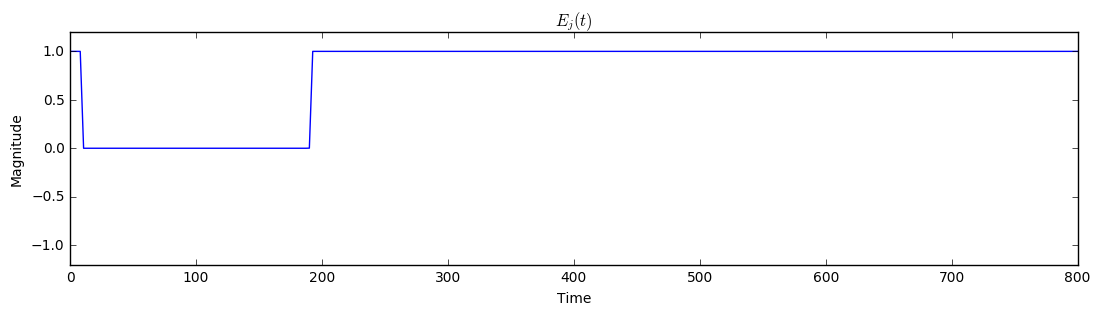

In [7]:
time_c_func = lambdify({'a','b','t','st','nEj','Ej'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=a,b=b,st=st,nEj=needed_Ej,Ej=Ej[0],t=tlist))
ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

# Operators

In [8]:
def n(N_states):
    return num(2*N_states+1, offset = -N_states)

def I(N_states):
    return identity(2*N_states+1)

def Hc(N_states = N[0], Ec = Ec[0], n_g = 0):
    return 4*Ec*(n(N_states)-n_g)**2

def Hj(N_states = N[0], Ej = Ej[0]):
    return -0.5*Ej*Qobj(np.diag(np.ones(2*N_states), -1)+np.diag(np.ones(2*N_states), 1))

def Hq(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
    return Hc(N_states,Ec) + Hj(N_states,Ej)

def c(N_states=N,evecs=evecs, Ej = Ej, Ec = Ec):
    return sum([n(N).matrix_element(evecs[j], evecs[j+1])/n(N).matrix_element(evecs[0], evecs[1])\
                    * evecs[j]*evecs[j+1].dag() for j in range(0, len(evecs)-1)])

def collapse_list(N_states = N,gamma_m = gamma_m):
    collapse_list = []
    if(gamma_m > 0):
        collapse_list.append(np.sqrt(gamma_m) * c())
    return collapse_list

def S_basis(evecs):
    S = [[el[0] for el in evec.data.toarray()] for evec in evecs ]
    return Qobj(S)
def convert_2toN(A2d,evecs):
    B2d = A2d.data.toarray()
    A = np.zeros(shape=(len(evecs),len(evecs)),dtype=np.complex128)
    A[0][0] = B2d[0][0]
    A[0][1] = B2d[0][1]
    A[1][0] = B2d[1][0]
    A[1][1] = B2d[1][1]
    Aq = Qobj(A)
    return Aq.transform(evecs,True)

def Hq_evecs(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
    return Hq(N_states,Ej,Ec).eigenstates()[1]
def Hq_evals(N_states = N[0], Ej = Ej[0], Ec = Ec[0]):
    return Hq(N_states,Ej,Ec).eigenstates()[0]
def Hqq_evecs(qubit):
    return Hq_evecs(N[qubit-1], Ej[qubit-1], Ec[qubit-1])
def Hqq_evals(qubit):
    return Hq_evals(N[qubit-1], Ej[qubit-1], Ec[qubit-1])
def Hqq(qubit):
    return Hq(N[qubit-1], Ej[qubit-1], Ec[qubit-1])

In [9]:
evecs = [Hqq_evecs(1),Hqq_evecs(2)]
evals = [Hqq_evals(1),Hqq_evals(2)]
psi0 = evecs[0][0]
print((evals[0][1]-evals[0][0]))
print((evals[0][2]-evals[0][1]))
w10 = [evals[0][1] - evals[0][0], evals[1][1] - evals[1][0]]
w21 = [evals[0][2] - evals[0][1], evals[1][2] - evals[1][1]]
print(w10)
print(w21)
#args['w'] = w10

8.72021202752
6.51868343811
[8.7202120275182402, 7.8995064742269481]
[6.5186834381082885, 5.3496493098973579]


In [18]:
Ej_space = np.linspace(4.35,4.37, 1000)

difs = []
for Ej_id, E_j in enumerate(Ej_space):
    evals, evecs = Hq(N[0],E_j,Ec[0]).eigenstates()
    difs.append(abs(evals[1] - evals[0] - w21[1]))
m = min(difs)
needed_Ej = 0
for d_id, d in enumerate(difs):
    if d == m:
        needed_Ej = (Ej_space[d_id])
        print(m)
print(needed_Ej)        
evals, evecs = Hq(N[0], needed_Ej, Ec[0]).eigenstates()
dE = evals[0]
for i,e in enumerate(evals):
    evals[i] -= dE
evals2 = Hqq_evals(2)
dE = evals2[0]
for i,e in enumerate(evals2):
    evals2[i] -= dE
print(evals[0:3])
print(evals2[0:3])

3.10700378314e-06
4.35938938939
[ 0.          5.3496462   7.06843482]
[  0.           7.89950647  13.24915578]


# Operators in tensor basis

In [12]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, I(N[1]))
    else:
        return tensor(I(N[0]), oper)
def THc(qubit, N = N, Ec = Ec, n_g = 0):
    return T(Hc(N[qubit-1],Ec[qubit-1]),qubit,N)    
def THj(qubit, N = N, Ej = Ej, n_g = 0):
    return T(Hj(N[qubit-1],Ej[qubit-1]),qubit,N) 

def THq(qubit):
    return THc(qubit) + THj(qubit)
    
def THqq():
    return THq(1) + THq(2)

def THic(N = N, Eu = Eu):
    return Eu * tensor(n(N[0]),n(N[1]))

def TprojN(lvl):
    def Tprojtmp(qubit, N = N):
        evecs = Hqq_evecs(qubit-1)
        A = np.zeros(shape=(len(evecs),len(evecs)),dtype=np.complex128)
        A[lvl][lvl] = 1
        return T(Qobj(A).transform(evecs,True),qubit,N)
    return Tprojtmp

def T2N(oper, qubit, N = N):
    return T(convert_2toN(oper,Hq(N[qubit-1],Ej[qubit-1],Ec[qubit-1]).eigenstates()[1]),qubit,N)

def TSx(qubit, N = N):
    return T2N(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T2N(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T2N(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T2N(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T2N(sigmam(),qubit, N)

In [13]:
Eu = 0.01
def THq_int(N = N, Ej = Ej, Ec = Ec, Eu = Eu):
    return THqq() + THic(N,Eu)

print(Eu)
print(time_coeff)
print(args)
def THq_t(time_coeff = time_coeff, N = N, Ej = Ej, Ec = Ec, Eu = Eu):
    print(Eu)
    return [THic(N,Eu) + THc(1) + THc(2) + THj(2), [THj(1) , time_coeff]] 


0.01
(1-(Ej-nEj)/Ej*0.5*(tanh((t-a)/st) - tanh((t-b)/st)))
{'a': 10, 'st': 0.01, 'b': 190, 'Ej': 12, 'nEj': 0}


In [21]:
def THq_evecs(N, Ej,Ec,Eu):
    return THq_int(N,Ej,Ec,Eu).eigenstates()[1]
def THq_evals(N=N, Ej=Ej,Ec=Ec,Eu=Eu):
    return THq_int(N,Ej,Ec,Eu).eigenstates()[0]

### Entanglement measures

In [38]:
ev = THq_evecs(N,[Ej[0],Ej[0]],[Ec[0],Ec[0]],Eu)[2]
entropy_vn(ev)

-4.1641017056584075e-11

In [47]:
Ej_space = np.linspace(1,20, 1000)
def tensor_basis(evecs1, evecs2):
    tb = []
    tb_tmp = [[tensor(ev1,ev2) for ev1 in evecs1] for ev2 in evecs2]
    for tbv in tb_tmp:
        tb +=(tbv)
    return tb
evecs2 = Hqq_evecs(2)
ent = [[entropy_vn(ev.transform(tensor_basis(Hq_evecs(N[0],E_j,Ec[0]),evecs2),True)) for ev in THq_evecs(N,[E_j,Ej[1]],Ec,Eu)[:4]] for E_j in Ej_space] 

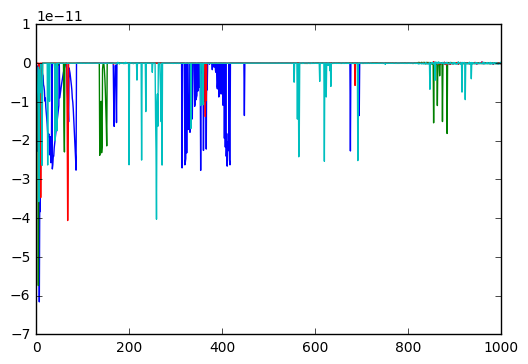

In [48]:
plt.plot(ent)

# Visualisation

In [14]:
def visualize_output(output):
    fig, axes = plt.subplots(3,1, figsize=(13,15), sharex=True)
    axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['0t','1t','2t']
    labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
    for idx, ax in enumerate(axes):
        ax.plot(tlist, output.expect[idx], label=labels[idx] + " state")
        #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
        #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
        ax.set_ylim(-1.5,1.1)
        ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
        ax.set_xlabel('Time')
    axes[0].set_ylabel('Occupation probability')

In [15]:
def Tvis_out(output):
    graphs = int(len(output.expect)/2)
    fig, axes2d = plt.subplots(graphs,2, figsize=(13,15), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist, output.expect[idy*graphs + idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')
    #axes[0].set_ylabel('Occupation probability')

# Dynamics 

In [16]:
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
ev1 = Hqq_evecs(1)
ev2 = Hqq_evecs(2)
#psi1 = (ev1[0]+ev1[1]) / (2**0.5)
#psi2 = (ev2[0]+ev2[1]) / (2**0.5)

#psi1 = ev1[0]
#psi2 = ev2[0]

psi1 = ev1[1]
psi2 = ev2[1]

Tpsi0 = tensor(psi1,psi2)
#Tpsi0 = tensor(ev1[0],ev2[0]) + tensor(ev1[1],ev2[0]) + tensor(ev1[0],ev2[1]) + tensor(ev1[1],ev2[1])
#Tpsi0 = (tensor(ev1[0],(ev2[1]+ev2[0])/ (2**0.5)) + tensor((ev1[1]+ev1[0])/ (2**0.5),ev2[0]))
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(THq_t(), Tpsi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(THq_t(), Tpsi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

0.01
{'a': 10, 'st': 0.01, 'w': 0, 'Ej': 12, 'b': 672.8760499074464, 'nEj': 4.3593893893893894}
0.01
10.0%. Run time:   2.89s. Est. time left: 00:00:00:25
20.0%. Run time:   5.84s. Est. time left: 00:00:00:23
30.0%. Run time:   8.71s. Est. time left: 00:00:00:20
40.0%. Run time:  11.87s. Est. time left: 00:00:00:17
50.0%. Run time:  15.71s. Est. time left: 00:00:00:15
60.0%. Run time:  19.37s. Est. time left: 00:00:00:12
70.0%. Run time:  22.42s. Est. time left: 00:00:00:09
80.0%. Run time:  25.64s. Est. time left: 00:00:00:06
90.0%. Run time:  28.74s. Est. time left: 00:00:00:03
Total run time:  32.06s


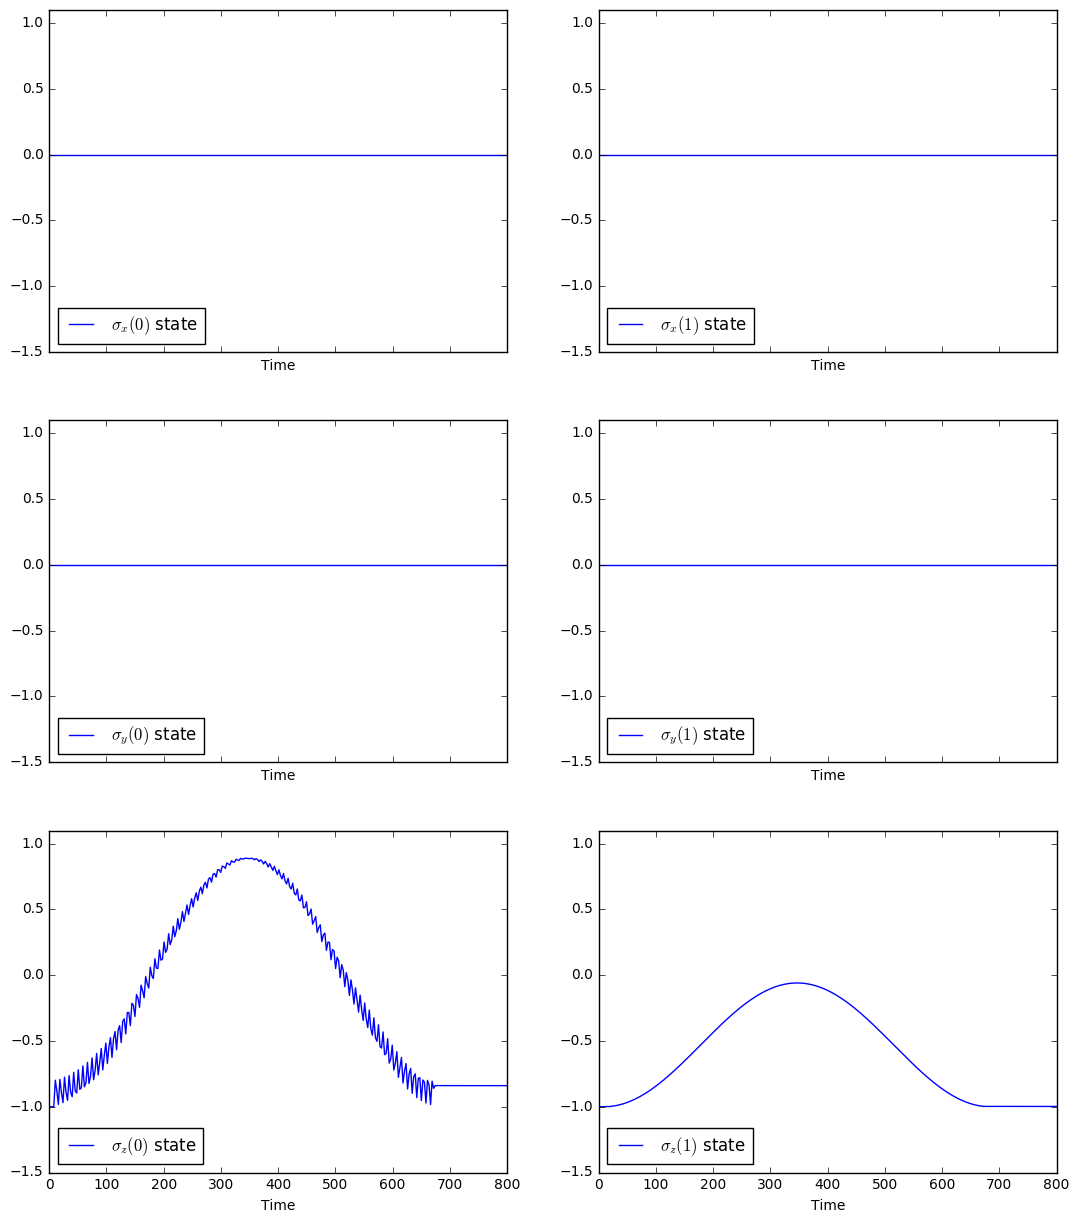

In [19]:
print(Eu)
args['a']=10
args['b']=args['a'] + np.pi/Eu*2.11
args['nEj'] = needed_Ej
args['w'] = 0
print(args)
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2) ]
#args['nEj'] = needed_Ej
Tvis_out(solve(expected))

In [46]:
def observe(output, operators, rotationFreq = w10):
    output2 = copy.deepcopy(output)
    output2.expect = []
    for i in range(len(operators)*2):
        output2.expect.append([])
    num_operators = len(operators)
    for time_step, state in enumerate(output.states):
        time = tlist_t / timesteps * time_step
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (-convert_2toN(sigmaz(), Hq_evecs())*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2

In [106]:
args['nEj'] = needed_Ej
args['w'] = 0
print(args)
print(time_coeff)
output = solve([])
#output2 = observe(output, [TSx, TSy, TSz, TprojN(0), TprojN(1), TprojN(2)], w10)
print("output2 is ready")
#output3 = observe(output, [TSx, TSy, TSz], [0,0])

{'st': 0.01, 'nEj': 4.3593593593593596, 'a': 10, 'Ej': 12, 'w': 0, 'b': 672.8760499074464}
(1-(Ej-nEj)/Ej*0.5*(tanh((t-a)/st) - tanh((t-b)/st)))
0.01
10.0%. Run time:   1.85s. Est. time left: 00:00:00:16
20.0%. Run time:   3.67s. Est. time left: 00:00:00:14
30.0%. Run time:   5.47s. Est. time left: 00:00:00:12
40.0%. Run time:   7.32s. Est. time left: 00:00:00:10
50.0%. Run time:   9.17s. Est. time left: 00:00:00:09
60.0%. Run time:  10.98s. Est. time left: 00:00:00:07
70.0%. Run time:  12.79s. Est. time left: 00:00:00:05
80.0%. Run time:  14.72s. Est. time left: 00:00:00:03
90.0%. Run time:  16.67s. Est. time left: 00:00:00:01
Total run time:  18.58s
output2 is ready


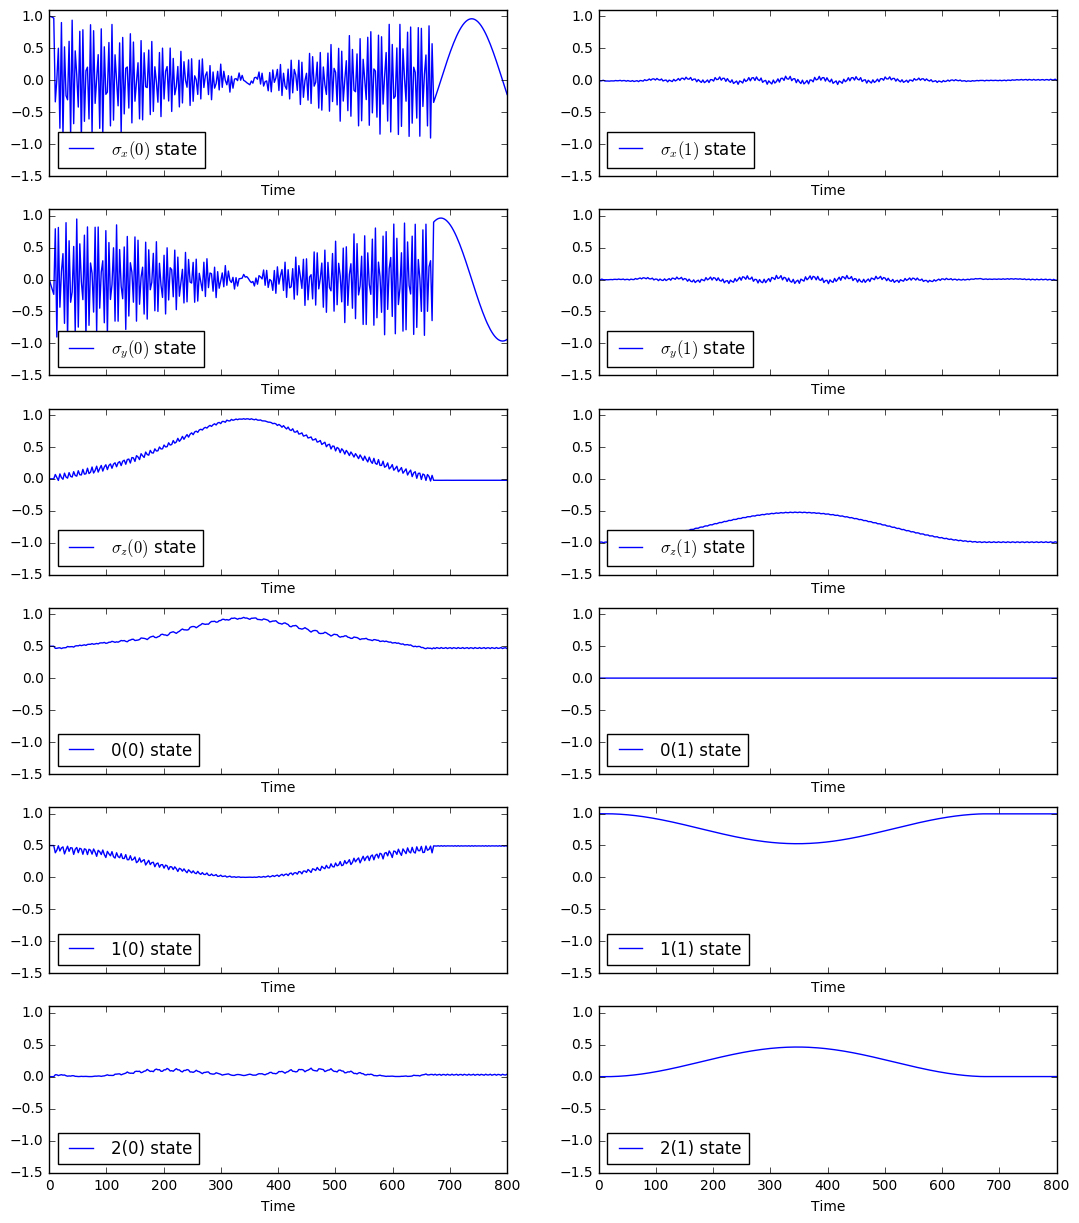

In [48]:
Tvis_out(output2)

In [52]:
def observe(output, operators, rotationFreq = w10):
    output2 = copy.deepcopy(output)
    output2.expect = [[],[],[],[],[],[]]
    num_operators = len(operators)
    for time_step, state in enumerate(output.states):
        time = tlist_t / timesteps * time_step
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (-convert_2toN(sigmaz(), Hq_evecs())*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2

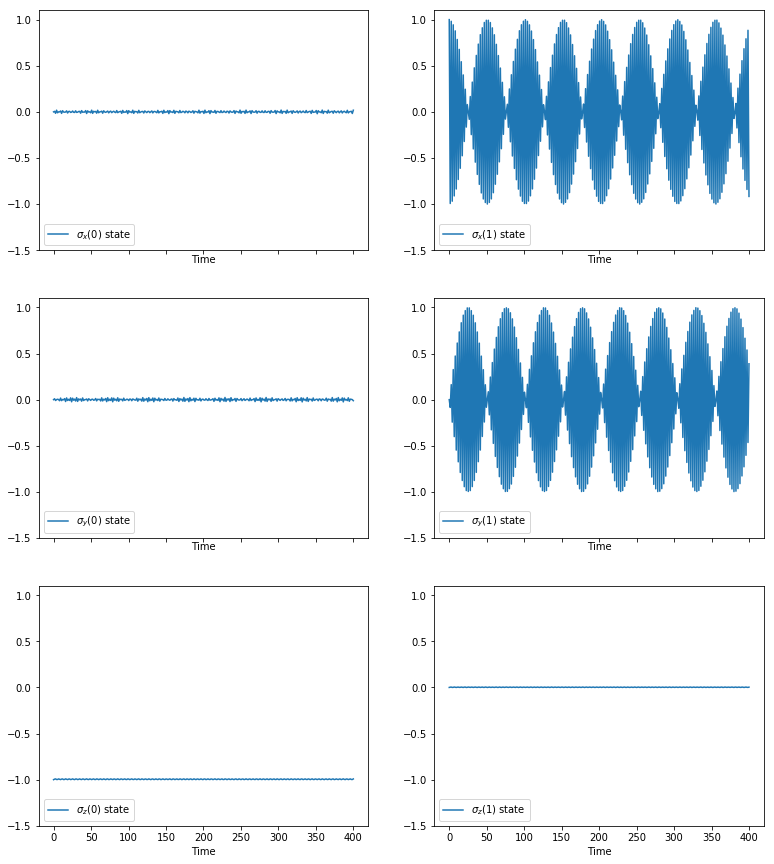

In [170]:
output3 = observe(output, [TSx, TSy, TSz], [0,0])
Tvis_out(output3)

In [78]:
evecs = [Hqq_evecs(1),Hqq_evecs(2)]
(Tpsi0.dag()*(output.states[0]*output.states[-1].dag())*Tpsi0).data.toarray()

array([[ 0.11542617+0.98705j]])

In [111]:
ev1,ev2 = Hqq_evecs(1), Hqq_evecs(2)
Tpsi = tensor(ev1[1],ev2[1])
(Tpsi.dag()*(output.states[0]*output.states[-1].dag())*Tpsi).data.toarray()*2

array([[-0.31032626+0.33859923j]])